# Using Transient Error Metrics
This notebook shows how to use the [transient error metrics](sec:transient_error_metrics) in ForceFinder, which is slightly more complex than using the error metrics for spectral problems. It will demonstrate:

- How to compute the different transient error metrics
- How to use the `LevelErrorGUI`
- How to use the `SpectrogramGUI`

In [1]:
import sdynpy as sdpy
import forcefinder as ff
import numpy as np
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt

## Example Beam System
This example uses the beam system that was developed [here](sec:example_beam_system) for a simple force reconstruction problem. An image of the beam system is shown below, where the blue arrows (above the beam) are the response DOFs for the source estimation and the red arrows (below the beam) are the source DOFs. 

```{note}
The nodes are labeled 101-109 from left to right. The translating direction on the beam (vertical on the page) is Z+ and the rotating direction is RY+.
```

```{figure} images/beam_system_basic_usage.svg
:alt: Example Beam System
:align: center
```

The example data for this beam system is generated using the following process:

1. The SDynPy `System` object for the beam is imported
2. Transient excitation is created for the source DOFs on the beam
3. Time responses to the transient excitation (as a SDynPy `TimeHistoryArray`) are computed for the beam using the `time_integrate` method for the beam `System` object
4. Random measurement errors are added to the time response
5. The FRFs are computed for the beam system using the `frequency_response` method for the beam `System` object

In [2]:
beam_system = sdpy.System.load(r'./example_system/example_system.npz')

### Making the Transient Excitation
The transient excitation for this example is composed of a single half-sine pulse for each excitation DOF. The excitation signal (and resulting response) has the sampling parameters that are listed below. Note that the time duration was selected to ensure that the free response of the beam is zero at the end of the time trace. 

In [3]:
sampling_rate = 1000 # Hz
time_duration = 3 # seconds
number_samples = sampling_rate*time_duration

time = np.arange(number_samples)/sampling_rate

In [4]:
def generate_half_sine_pulse(duration, amplitude):
    """
    Generates a simple half-sine pulse for the example excitation. Most of the variables 
    are pulled from elsewhere in the notebook. The pulse duration is rounded up to the 
    first sample after the duration.
    """
    duration = int(duration*sampling_rate)/sampling_rate
    pulse_time = np.arange(int(duration*sampling_rate)+1)/sampling_rate
    pulse_frequency = np.pi / duration
    return amplitude*np.sin(pulse_frequency*pulse_time)

The pulses for the different excitation DOFs use different pulse durations and amplitudes to add some complexity to the ISE problem. Additionally, the pulses are spaced apart so the second pulse happens while the beam is still in free response from the first pulse. 

In [5]:
pulse1 = generate_half_sine_pulse(0.005, 10)
pulse2 = generate_half_sine_pulse(0.01, 4)

raw_signal = np.zeros((2, number_samples), dtype=float)
raw_signal[0, np.arange(pulse1.shape[0])+400] += pulse1
raw_signal[1, np.arange(pulse2.shape[0])+700] += pulse2

The pulse is filtered using 10-450 Hz bandpass filter to mitigate force reconstruction issues from low frequency response or excitation past the Nyquist frequency.

In [6]:
sos_filter = butter(10, (10, 450), btype='bandpass', 
                    output='sos', fs=sampling_rate)

filtered_signal = sosfiltfilt(sos_filter, raw_signal)

sdynpy_signal = sdpy.time_history_array(time, filtered_signal, 
                    sdpy.coordinate_array(node=[103,108], direction=3)[...,np.newaxis])

The excitation time traces and frequency spectra are shown in the plots below, which clearly show the filtering artifacts and excitation bandwidth.

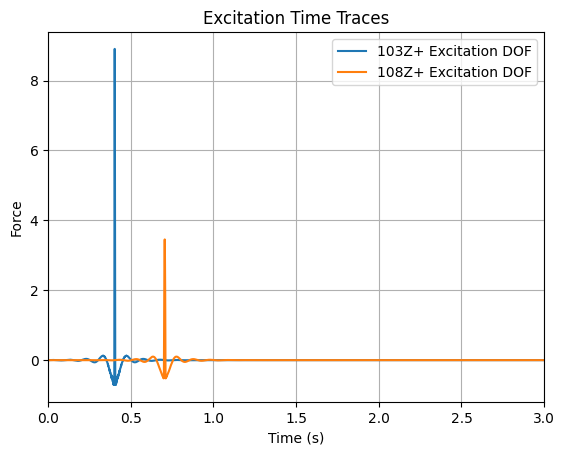

In [7]:
plt.figure()
plt.plot(sdynpy_signal[0].abscissa, sdynpy_signal[0].ordinate, 
         label='103Z+ Excitation DOF')
plt.plot(sdynpy_signal[1].abscissa, sdynpy_signal[1].ordinate, 
         label='108Z+ Excitation DOF')
plt.xlim(left=0, right=3)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.title('Excitation Time Traces')
plt.grid()

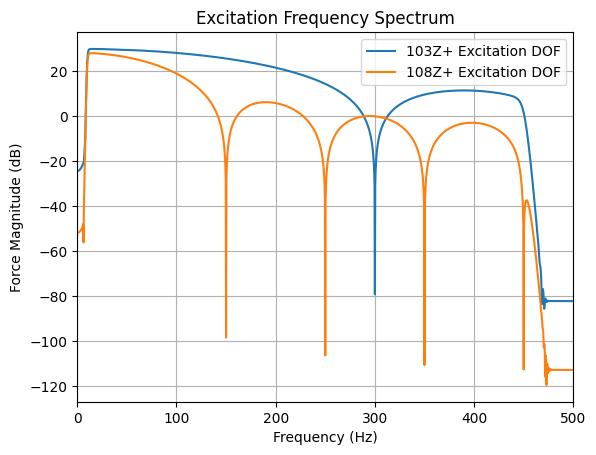

In [8]:
sdynpy_signal_fft = sdynpy_signal.fft()

plt.figure()
plt.plot(sdynpy_signal_fft[0].abscissa, 20*np.log10(np.abs(sdynpy_signal_fft[0].ordinate)), 
         label='103Z+ Excitation DOF')
plt.plot(sdynpy_signal_fft[1].abscissa, 20*np.log10(np.abs(sdynpy_signal_fft[1].ordinate)), 
         label='108Z+ Excitation DOF')
plt.xlim(left=0, right=500)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Force Magnitude (dB)')
plt.title('Excitation Frequency Spectrum')
plt.grid()

### Computing the Time Response
The responses are computed with time integration using an over sample factor of ten. The displacement derivative is set to two, meaning that the computed time responses are provided as accelerations. Random white noise is added to the computed response to simulate measurement errors. The amplitude of this noise was selected to 1% of the maximum signal amplitude (per channel). A sample plot of the response time trace for DOF 102Z+ is shown in the plot below.

```{note}
The `time_integrate` method computes time responses for all the DOFs in the beam even though only a subset of the responses will be used for an ISE problem.
```

In [9]:
time_response, forces = beam_system.time_integrate(sdynpy_signal, 
                                                   integration_oversample=10, 
                                                   displacement_derivative=2) 

noise_multiplier = np.abs(time_response.ordinate).max(axis=1)[...,np.newaxis]*0.01
time_response.ordinate += np.random.randn(time_response.shape[0], number_samples)*noise_multiplier

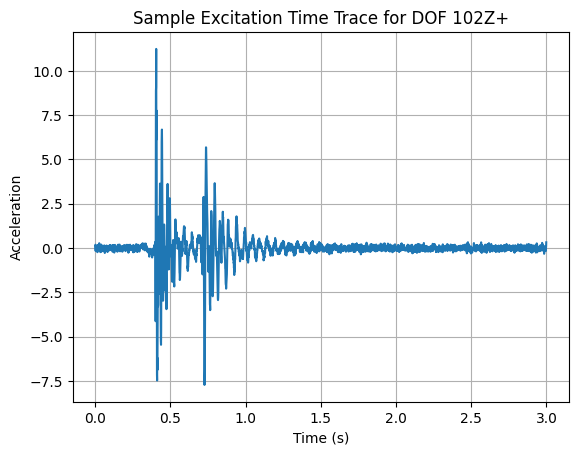

In [10]:
ax = time_response[2].plot()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Acceleration')
ax.set_title('Sample Excitation Time Trace for DOF 102Z+')
ax.grid()

### Computing the FRFs
The FRFs are computed with a frequency resolution of 1 Hz and the reference `CoordinateArray` from the excitation signal. The displacement derivative is set to two, meaning that the FRFs are in accelerance format.  

In [11]:
frequency = np.arange(sampling_rate/2+1)

frfs = beam_system.frequency_response(frequency,
                                      references=sdynpy_signal.response_coordinate, 
                                      displacement_derivative=2)

## Using the SPR Object
The example SPR object is created using the standard initialization function. The training response DOFs are explicitly defined, since the time responses were computed fo all the DOFs in the beam.

```{note}
The training response DOFs were selected to simplify the inverse problem do not necessarily represent a good set of response DOFs for a source estimation problem.
```

In [12]:
training_response_dofs = sdpy.coordinate_array(node=[102,104,106,108], direction=3)

example_spr = ff.TransientSourcePathReceiver(frfs=frfs, target_response=time_response,
                                training_response_coordinate=training_response_dofs)

### Estimating the Sources
The sources are estimated using the standard pseudo-inverse method, which is called with the `manual_inverse` method and setting the `inverse_method` kwarg to `standard`. 

In [13]:
example_spr.manual_inverse(inverse_method='standard')

'TransientSourcePathReceiver object with 2 reference coordinates, 18 target response coordinates, and 4 training response coordinates'

### Evaluating the DOF-DOF Reconstructed Response Error with Direct Time Trace Comparisons
Simple DOF-DOF comparisons of the reconstructed and truth response time traces can be used to quickly evaluate the errors in the reconstructed response, as shown below. This type of comparison is straightforward for this example since the is very little error. However, direct time trace comparisons can be extremely difficult and misleading when there are any errors in the waveform shape of reconstructed response (like what could happen when there are minor modeling errors).

```{tip}
The `GUIPlot` tool will not directly plot in Jupyter Notebooks. The magic command `%matplotlib qt` must be used to open the plot in a separate window. Refer to IDE help documents to set the appropriate plotting backend.  
```

In [14]:
sdpy.GUIPlot(example_spr.training_response,
             example_spr.reconstructed_training_response)

```{figure} images/example_transient_gui_plot.png
:alt: Example Time Trace Comparisons
:align: center
```

### Evaluating the Reconstructed Response Error with Summary Metrics
Sometimes, it is convenient to use a summary metric to quickly evaluate the accuracy of the reconstructed response. This example uses the [global RMS error](sec:global_rms_error) summary metric to demonstrate this process. The transient error metrics require some additional inputs compared to the frequency domain error metrics, as described [here](sec:transient_error_metrics). 

The global RMS error indicates that the estimated sources reconstruct the training responses with good accuracy, since there is very low error in the segments where there is free response. There are higher errors in the second half of the time range where the responses are dominated by the simulated measurement errors. This error trend can also be seen in the time trace comparison that was shown above. 

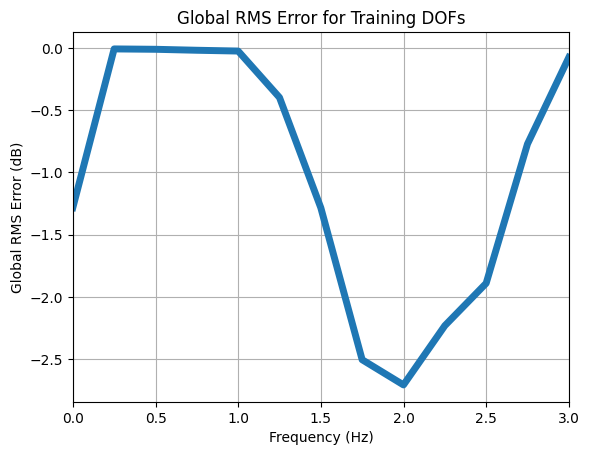

In [15]:
global_error = example_spr.global_rms_error(channel_set='training', 
                                            frame_length=0.5, # seconds
                                            overlap=0.5)
ax = global_error.plot(plot_kwargs={'linewidth':5})
ax.set_ylabel('Global RMS Error (dB)')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('Global RMS Error for Training DOFs')
ax.grid()
ax.set_xlim(left=0, right=3);

### Using the Level Error GUI
Level based errors in the reconstructed response can be reviewed on a DOF-DOF basis with the [`time_varying_level_error`](sec:time_varying_level_error) and [`time_varying_trac`](sec:time_varying_trac). This example demonstrates the `time_varying_trac` method.

In [16]:
trac_error = example_spr.time_varying_trac(frame_length=0.5, 
                                           overlap=0.5)

The `time_varying_level_error` and `time_varying_trac` methods return the errors in a SDynPy `TimeHistoryArray` and can be reviewed with the SDynPy `GUIPlot` tool or the `LevelErrorGUI`. The `LevelErrorGUI` differs from `GUIPlot` in that it generates a window with two plots, where one plot compares the truth and reconstructed response time traces and the second plot shows the DOF-DOF error metric. An image of the example `LevelErrorGUI` is shown below.

```{tip}
Like the `GUIPlot` tool, the `LevelErrorGUI` will not directly plot in Jupyter Notebooks. The magic command `%matplotlib qt` must be used to open these tools in a separate window. Refer to IDE help documents to set the appropriate plotting backend.  
```

In [17]:
ff.LevelErrorGUI(example_spr.training_response, 
                 example_spr.reconstructed_training_response, 
                 trac_error, 
                 data_axis_label='Acceleration (m/s$^2$)', 
                 level_axis_label='TRAC')

'Basic GUI plot for transient level errors'

```{figure} images/example_level_error_gui.png
:alt: Example Level Error GUI
:align: center
```

### Computing and Reviewing th Spectrogram Error
While the time trace comparisons, summary metrics, and level errors make it easy to evaluate the accuracy of the reconstructed responses compared to the truth responses, it can be difficult to interpret why errors exist in these metrics. The [spectrogram error](sec:spectrogram_error) can provide useful information in this scenario, since it gives the practitioner the ability to evaluate errors on a time-frequency basis. 

As such, the spectrogram error can be used to see if the errors in the reconstructed response are focused in specific frequency ranges (e.g., resonances or anti-resonances) or if they are broadband in nature. The spectrogram error is computed on a DOF-DOF basis with the `compute_error_stft` function and is plotted with the `SpectrogramGUI`, as shown below. 

In [18]:
error_stft = ff.transient_quality_metrics.compute_error_stft(example_spr,
                                                        frame_length=0.5,
                                                        overlap=0.5)

```{tip}
Like the other GUI plotting tools, the `SpectrogramGUI` will not plot directly in Jupyter Notebooks and an appropriate plotting backend must be set to open the plot in a separate window.
```

```{tip}
The `SpectrogramGUI` has colorbar options to determine the limits and colormap. These options cannot be changed once the plot window has been opened.
```

In [19]:
ff.SpectrogramGUI(error_stft, colormap='coolwarm', 
                  colormap_limits=[-10,10])

'Basic GUI plot for spectrograms'

```{figure} images/example_spectrogram_gui.png
:alt: Example Spectrogram GUI
:align: center
```

Unfortunately, the spectrogram error can be difficult to interpret, since the error level is independent of the response amplitude. This issue can be seen in the spectrogram error that is shown above, where there are significant errors in the second half of the time range, which has has a near-zero response amplitude that is dominated by the the simulated measurement errors. As such, any errors in the second of the time range are inconsequential to the overall response, regardless of the amplitude.

The `normalize_by_rms` option can help mitigate this issue with interpretability because it normalizes the spectrogram error for the different time segments by the relative RMS levels. Consequently, the spectrogram error for a given time segment will be scaled down if it is in a low responding time segment. An example spectrogram error plot, which uses the `normalize_by_rms` option, is shown below. As expected, it is much easier to identify the errors in the high responding time segments in this spectrogram compared to the non-normalized spectrogram that was shown above. 

In [20]:
error_stft_normalized = ff.transient_quality_metrics.compute_error_stft(example_spr,
                                                                frame_length=0.5,
                                                                overlap=0.5, 
                                                                normalize_by_rms=True)

In [21]:
ff.SpectrogramGUI(error_stft_normalized, colormap='coolwarm', 
                  colormap_limits=[-10,10])

'Basic GUI plot for spectrograms'

```{figure} images/example_normalized_spectrogram_gui.png
:alt: Example Normalized Spectrogram GUI
:align: center
```